运行完整分析（DoWhy + EconML）...

=== 促销活动因果效应分析 (DoWhy) ===

识别的因果效应:
 Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                               
───────────────(E[total_revenue|day_of_week,is_weekend,loyalty_orders])
d[hasₚᵣₒₘₒₜᵢₒₙ]                                                        
Estimand assumption 1, Unconfoundedness: If U→{has_promotion} and U→total_revenue then P(total_revenue|has_promotion,day_of_week,is_weekend,loyalty_orders,U) = P(total_revenue|has_promotion,day_of_week,is_weekend,loyalty_orders)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                 -1⎤
 ⎢       d                       ⎛       d                        ⎞  ⎥
E⎢────────────────(totalᵣₑᵥₑₙᵤₑ)⋅⎜────────────────([hasₚᵣₒₘₒₜᵢₒₙ])⎟  ⎥
 ⎣d[is_member_day]               ⎝d[is_member_day]                ⎠  ⎦
Estimand assumption 1, As-if-random: If 

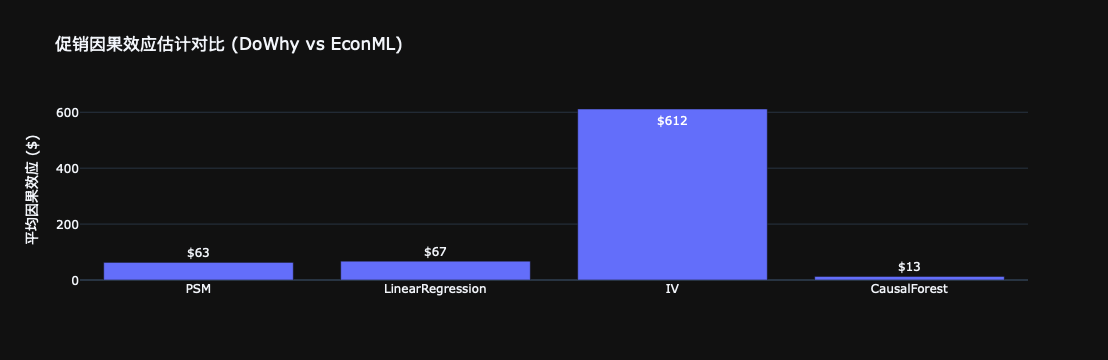

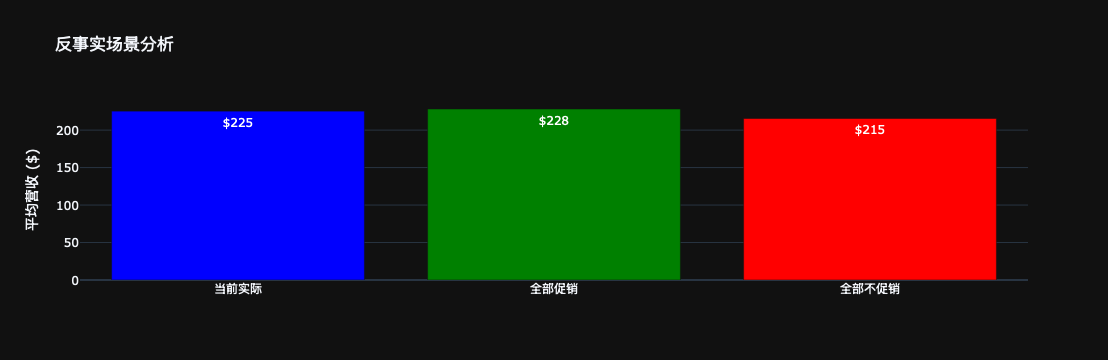


仅运行 EconML 分析...

=== 促销活动因果效应分析 (EconML) ===

CausalForest ATE: $12.66

=== 反事实推断 (EconML) ===
当前平均营收        : $225.33
全部促销 反事实营收 : $228.15  (+ 1.2%)
全部停促销反事实营收: $215.49  ( 4.4% ↓)


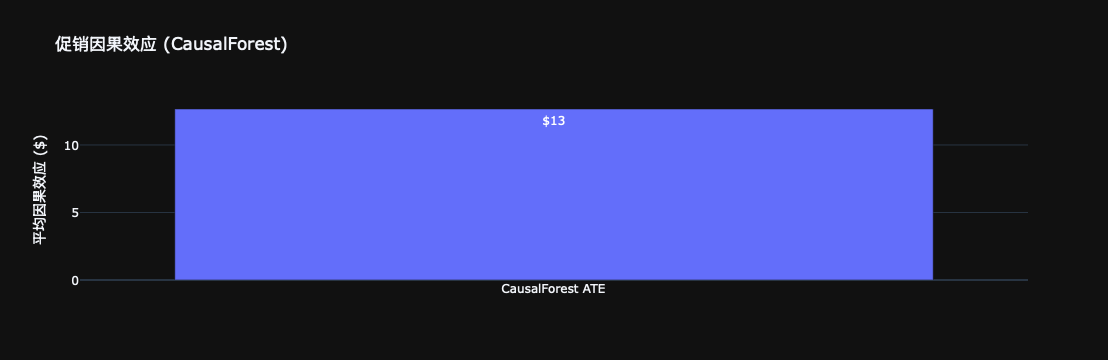

In [2]:
"""
基于 UMe 茶饮销售数据，评估天气、节假日、促销等因素的因果影响
"""

import pandas as pd
import numpy as np
pd.options.display.max_columns = None

from datetime import datetime, timedelta
import clickhouse_connect
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings; warnings.filterwarnings("ignore")

# 因果推断
from dowhy import CausalModel
import statsmodels.api as sm

# EconML（异质效应分析）
from econml.metalearners import TLearner
from econml.dml import CausalForestDML, LinearDML

# 可视化
import plotly.graph_objects as go


class FBRCausalInference:
    """FBR 因果推断分析引擎 - 修复版"""

    # ------------------------------------------------------------
    # 0. 初始化
    # ------------------------------------------------------------
    def __init__(self, ch_config: dict):
        self.ch_client = clickhouse_connect.get_client(**ch_config)
        self.scaler = StandardScaler()

    # ------------------------------------------------------------
    # 1. 数据抽取
    # ------------------------------------------------------------
    def load_integrated_data(self, start_date: str, end_date: str) -> pd.DataFrame:
        """拉取日 × 店铺销售聚合 + 类别特征"""
        sales_query = f"""
        WITH
            toDate(created_at_pt)          AS dt,
            toDayOfWeek(created_at_pt)     AS day_of_week,
            toHour(created_at_pt)          AS hour_of_day,
            substring(location_name, position(location_name,'-')+1, 2) AS state
        SELECT
            dt  AS date,
            location_id,
            location_name,
            state,
            day_of_week,
            hour_of_day,
            /* 指标 */
            countDistinct(order_id)                              AS order_count,
            sum(item_total_amt)                                  AS total_revenue,
            avg(item_total_amt)                                  AS avg_order_value,
            sum(item_discount)                                   AS total_discount,
            sum(item_discount>0)                                 AS discount_orders,
            countDistinct(customer_id)                           AS unique_customers,
            sum(is_loyalty)                                      AS loyalty_orders,
            sum(arrayExists(x->x='BOGO',assumeNotNull(campaign_names))) AS bogo_orders,
            countDistinct(category_name)                         AS category_diversity
        FROM dw.fact_order_item_variations
        WHERE
            created_at_pt >= '{start_date}'
            AND created_at_pt <= '{end_date}'
            AND pay_status = 'COMPLETED'
        GROUP BY
            date, location_id, location_name, state, day_of_week, hour_of_day
        ORDER BY
            date, location_id
        """
        sales_df = self.ch_client.query_df(sales_query)

        # —— 类别特征（示例）———————————————————————————
        category_query = f"""
        SELECT
            toDate(created_at_pt) AS date,
            location_id,
            category_name,
            count()               AS category_orders,
            sum(item_total_amt)   AS category_revenue
        FROM dw.fact_order_item_variations
        WHERE created_at_pt BETWEEN '{start_date}' AND '{end_date}'
              AND pay_status='COMPLETED'
        GROUP BY date, location_id, category_name
        """
        cat_df = self.ch_client.query_df(category_query)

        hot_categories = ['Milk Tea', 'Fruit Tea', 'Coffee', 'Snacks']
        for cat in hot_categories:
            tmp = cat_df[cat_df['category_name'] == cat].copy()
            tmp = tmp.rename(columns={
                'category_orders': f"{cat.lower().replace(' ','_')}_orders",
                'category_revenue': f"{cat.lower().replace(' ','_')}_revenue"
            })
            sales_df = sales_df.merge(
                tmp[['date','location_id',
                     f"{cat.lower().replace(' ','_')}_orders",
                     f"{cat.lower().replace(' ','_')}_revenue"]],
                on=['date','location_id'],
                how='left'
            )

        return sales_df.fillna(0)

    # ------------------------------------------------------------
    # 2. 衍生处理变量
    # ------------------------------------------------------------
    @staticmethod
    def create_treatment_variables(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['has_promotion']      = (df['total_discount'] > 0).astype(int)
        df['promotion_intensity'] = df['total_discount'].astype(float) /(df['total_revenue'].astype(float)  + df['total_discount'].astype(float)  + 1e-3)

        df['has_bogo']    = (df['bogo_orders'] > 0).astype(int)
        df['is_weekend']  = df['day_of_week'].isin([6,7]).astype(int)
        df['is_member_day'] = (df['day_of_week'] == 3).astype(int)
        df['is_peak_hour'] = df.groupby('location_id')['order_count'].transform(lambda x: (x > x.quantile(.75)).astype(int))
        return df

    # ------------------------------------------------------------
    # 3. 促销效应分析（DoWhy + EconML）
    # ------------------------------------------------------------
    def analyze_promotion_effect(self, df: pd.DataFrame, method='both') -> dict:
        """
        分析促销效应
        method: 'dowhy', 'econml', 'both'
        """
        results = {}

        if method in ['dowhy', 'both']:
            dowhy_results = self._analyze_promotion_dowhy(df)
            results['DoWhy'] = dowhy_results

        if method in ['econml', 'both']:
            econml_results = self._analyze_promotion_econml(df)
            results['EconML'] = econml_results

        return results

    # ------------------------------------------------------------
    # 3.1 DoWhy 方法（修复版）
    # ------------------------------------------------------------
    def _analyze_promotion_dowhy(self, df: pd.DataFrame) -> dict:
        print("\n=== 促销活动因果效应分析 (DoWhy) ===\n")

        treatment = 'has_promotion'
        outcome   = 'total_revenue'
        confs     = ['day_of_week','unique_customers',
                     'category_diversity','loyalty_orders','is_weekend']

        # 数值化处理
        df = self._force_numeric(df, [treatment,outcome]+confs).dropna()

        # 因果图定义
        graph = """
        digraph {
            is_member_day -> has_promotion;
            has_promotion -> total_revenue;

            day_of_week -> {has_promotion total_revenue};
            unique_customers -> total_revenue;
            category_diversity -> total_revenue;
            loyalty_orders -> {has_promotion total_revenue};
            is_weekend -> {has_promotion total_revenue};
        }
        """

        model = CausalModel(df, treatment, outcome, graph)
        ident = model.identify_effect(proceed_when_unidentifiable=True)
        print("识别的因果效应:\n", ident)

        results = {}

        # ① PSM
        try:
            psm = model.estimate_effect(ident,
                     method_name="backdoor.propensity_score_matching")
            results['PSM'] = round(psm.value,2)
            print(f"倾向得分匹配估计: {psm.value:.2f}")
        except Exception as e:
            print("PSM 失败:", e)

        # ② 线性回归
        lr = model.estimate_effect(ident,
                     method_name="backdoor.linear_regression")
        results['LinearRegression'] = round(lr.value,2)
        print(f"线性回归估计: {lr.value:.2f}")

        # ③ 工具变量
        try:
            iv = model.estimate_effect(ident,
                method_name="iv.instrumental_variable",
                method_params={'iv_instrument_name':'is_member_day'})
            results['IV'] = round(iv.value,2)
            print(f"工具变量估计: {iv.value:.2f}")
        except Exception as e:
            print("IV 估计失败:", e)

        # ④ 反事实分析（修复版）
        self._counterfactual_dowhy_fixed(model, ident, df, lr,
                                         treatment=treatment, outcome=outcome)

        return results

    # ------------------------------------------------------------
    # 3.2 修复的反事实分析
    # ------------------------------------------------------------
    def _counterfactual_dowhy_fixed(self, model, ident, df, estimator, treatment, outcome):
        """修复版：使用已估计的模型进行反事实推断"""
        try:
            # 获取当前平均值
            y_actual = df[outcome].mean()

            # 方法1：使用估计器的系数进行反事实计算
            if hasattr(estimator, 'estimator') and hasattr(estimator.estimator, 'model'):
                coef = estimator.estimator.model.params.get(treatment, 0)

                # 计算反事实
                y_all_promo = y_actual + coef * (1 - df[treatment].mean())
                y_no_promo = y_actual - coef * df[treatment].mean()

                print("\n=== 反事实推断 (基于线性模型) ===")
                print(f"当前平均营收        : ${y_actual:.2f}")
                print(f"全部促销 反事实营收 : ${y_all_promo:.2f}  (+{(y_all_promo/y_actual-1)*100:4.1f}%)")
                print(f"全部停促销反事实营收: ${y_no_promo:.2f}  ({(1-y_no_promo/y_actual)*100:4.1f}% ↓)")
            else:
                # 方法2：简单基于ATE的反事实
                ate = estimator.value
                promo_rate = df[treatment].mean()

                y_all_promo = y_actual + ate * (1 - promo_rate)
                y_no_promo = y_actual - ate * promo_rate

                print("\n=== 反事实推断 (基于ATE) ===")
                print(f"当前平均营收        : ${y_actual:.2f}")
                print(f"全部促销 反事实营收 : ${y_all_promo:.2f}  (+{(y_all_promo/y_actual-1)*100:4.1f}%)")
                print(f"全部停促销反事实营收: ${y_no_promo:.2f}  ({(1-y_no_promo/y_actual)*100:4.1f}% ↓)")

        except Exception as e:
            print(f"反事实分析出错: {e}")

    # ------------------------------------------------------------
    # 3.3 EconML 方法
    # ------------------------------------------------------------
    def _analyze_promotion_econml(self, df: pd.DataFrame) -> dict:
        """使用EconML的CausalForest进行促销效应分析"""
        print("\n=== 促销活动因果效应分析 (EconML) ===\n")

        treatment = 'has_promotion'
        outcome = 'total_revenue'
        feature_cols = ['day_of_week', 'unique_customers', 'category_diversity',
                       'loyalty_orders', 'is_weekend']

        # 数据预处理
        df = df.copy()
        df[feature_cols + [outcome]] = df[feature_cols + [outcome]].apply(
            pd.to_numeric, errors='coerce')
        df = df.dropna(subset=feature_cols + [outcome])

        Y = df[outcome].values
        T = df[treatment].values.astype(int)  # 确保是整数类型
        X = df[feature_cols].values

        # 分割训练集和测试集
        X_tr, X_te, T_tr, T_te, Y_tr, Y_te = train_test_split(
            X, T, Y, test_size=0.2, random_state=42)

        # 训练CausalForest模型
        # 对于二值处理变量，使用 discrete_treatment=True
        cf = CausalForestDML(
            model_t='auto',  # 让模型自动选择合适的第一阶段模型
            model_y=RandomForestRegressor(n_estimators=200, max_depth=6),
            discrete_treatment=True,  # 指定处理变量是离散的
            n_estimators=500,  # 减少树的数量以加快训练
            min_samples_leaf=50,
            random_state=42
        )

        try:
            cf.fit(Y_tr, T_tr, X=X_tr)

            # 计算效应
            cate_te = cf.effect(X_te)
            ate = float(cate_te.mean())

            # 反事实分析
            rev_actual = Y_te.mean()

            # 对未促销的样本，计算如果促销的效应
            no_promo_idx = T_te == 0
            promo_effect_on_no_promo = cate_te[no_promo_idx].mean() if no_promo_idx.any() else 0

            # 对已促销的样本，计算如果不促销的效应（负效应）
            promo_idx = T_te == 1
            no_promo_effect_on_promo = -cate_te[promo_idx].mean() if promo_idx.any() else 0

            # 计算反事实场景
            promo_rate = T_te.mean()
            rev_all_promo = rev_actual + promo_effect_on_no_promo * (1 - promo_rate)
            rev_no_promo = rev_actual + no_promo_effect_on_promo * promo_rate

            print(f"CausalForest ATE: ${ate:.2f}")
            print(f"\n=== 反事实推断 (EconML) ===")
            print(f"当前平均营收        : ${rev_actual:.2f}")
            print(f"全部促销 反事实营收 : ${rev_all_promo:.2f}  (+{(rev_all_promo/rev_actual-1)*100:4.1f}%)")
            print(f"全部停促销反事实营收: ${rev_no_promo:.2f}  ({(1-rev_no_promo/rev_actual)*100:4.1f}% ↓)")

            results = {
                'CausalForest_ATE': ate,
                'Actual_Revenue': rev_actual,
                'AllPromo_Revenue': rev_all_promo,
                'NoPromo_Revenue': rev_no_promo,
                'CATE_std': float(cate_te.std())
            }

            return results

        except Exception as e:
            print(f"EconML分析失败: {e}")
            print("尝试使用更简单的模型...")

            # 降级到线性DML模型
            ldml = LinearDML(
                model_t='auto',
                model_y=RandomForestRegressor(n_estimators=100, max_depth=5),
                discrete_treatment=True,
                random_state=42
            )

            ldml.fit(Y_tr, T_tr, X=X_tr)
            ate = ldml.ate(X_te)

            print(f"\nLinearDML ATE: ${ate:.2f}")

            return {
                'LinearDML_ATE': ate,
                'Actual_Revenue': Y_te.mean(),
                'Fallback': True
            }

    # ------------------------------------------------------------
    # 4. 天气效应（EconML TLearner）
    # ------------------------------------------------------------
    def analyze_weather_effect(self, sales_df, weather_df):
        print("\n=== 天气因果效应分析 (EconML TLearner) ===\n")

        merged = sales_df.merge(weather_df, on=['date','state'], how='left')
        merged['is_hot'] = (merged['temperature_2m_max'] > 30).astype(int)

        Y = merged['total_revenue'].values
        T = merged['is_hot'].values
        X = merged[['day_of_week','unique_customers','category_diversity']].values

        t_learner = TLearner(models=RandomForestRegressor(n_estimators=200,
                                                          random_state=42))
        t_learner.fit(Y, T, X=X)
        cate = t_learner.effect(X)

        print(f"高温天气平均因果效应: ${cate.mean():.2f} (±{cate.std():.2f})")
        return merged, cate

    # ------------------------------------------------------------
    # 5. 小工具
    # ------------------------------------------------------------
    @staticmethod
    def _force_numeric(df, cols):
        """把 object / Decimal 全转 float64，UInt* 转 int64"""
        out = df.copy()
        for c in cols:
            if c in out.columns:
                out[c] = pd.to_numeric(out[c], errors='coerce')
        return out

    # ------------------------------------------------------------
    # 6. 可视化
    # ------------------------------------------------------------
    @staticmethod
    def visualize_causal_effects(effects: dict):
        """可视化因果效应对比"""
        if 'DoWhy' in effects and 'EconML' in effects:
            # 组合显示
            dowhy_vals = effects['DoWhy']
            econml_res = effects['EconML']

            if 'Fallback' in econml_res and econml_res['Fallback']:
                methods = list(dowhy_vals.keys()) + ['LinearDML']
                values = list(dowhy_vals.values()) + [econml_res.get('LinearDML_ATE', 0)]
            else:
                methods = list(dowhy_vals.keys()) + ['CausalForest']
                values = list(dowhy_vals.values()) + [econml_res.get('CausalForest_ATE', 0)]

            fig = go.Figure(go.Bar(
                x=methods,
                y=values,
                text=[f"${v:.0f}" for v in values],
                textposition='auto'
            ))
            fig.update_yaxes(title='平均因果效应 ($)')
            fig.update_layout(title='促销因果效应估计对比 (DoWhy vs EconML)')

        elif 'DoWhy' in effects:
            fig = go.Figure(go.Bar(
                x=list(effects['DoWhy'].keys()),
                y=list(effects['DoWhy'].values()),
                text=[f"${v:.0f}" for v in effects['DoWhy'].values()],
                textposition='auto'
            ))
            fig.update_yaxes(title='平均因果效应 ($)')
            fig.update_layout(title='促销因果效应估计对比 (DoWhy)')

        else:
            # EconML only
            econml_res = effects['EconML']
            if 'Fallback' in econml_res and econml_res['Fallback']:
                ate = econml_res.get('LinearDML_ATE', 0)
                title = '促销因果效应 (LinearDML)'
                label = 'LinearDML ATE'
            else:
                ate = econml_res.get('CausalForest_ATE', 0)
                title = '促销因果效应 (CausalForest)'
                label = 'CausalForest ATE'

            fig = go.Figure(go.Bar(
                x=[label],
                y=[ate],
                text=[f"${ate:.0f}"],
                textposition='auto'
            ))
            fig.update_yaxes(title='平均因果效应 ($)')
            fig.update_layout(title=title)

        return fig

    @staticmethod
    def visualize_counterfactual_scenarios(results: dict):
        """可视化反事实场景对比"""
        scenarios = ['当前实际', '全部促销', '全部不促销']

        if 'EconML' in results:
            econml_res = results['EconML']

            # 检查是否是 fallback 模式
            if 'Fallback' in econml_res and econml_res['Fallback']:
                print("使用 LinearDML 结果，反事实场景可视化不可用")
                return None

            values = [
                econml_res.get('Actual_Revenue', 0),
                econml_res.get('AllPromo_Revenue', 0),
                econml_res.get('NoPromo_Revenue', 0)
            ]
        else:
            # 从DoWhy结果推算（简化版）
            return None

        fig = go.Figure(go.Bar(
            x=scenarios,
            y=values,
            text=[f"${v:.0f}" for v in values],
            textposition='auto',
            marker_color=['blue', 'green', 'red']
        ))

        fig.update_yaxes(title='平均营收 ($)')
        fig.update_layout(title='反事实场景分析')

        return fig


# ──────────────────────────────────────────────
# 使用示例
# ──────────────────────────────────────────────
if __name__ == "__main__":
    CLICKHOUSE_CONFIG = dict(
        host="clickhouse-0-0.umetea.net",
        port=443,
        database="dw",
        user="ml_ume",
        password="hDAoDvg8x552bH",
        verify=False,
    )

    ci = FBRCausalInference(CLICKHOUSE_CONFIG)

    # 加载数据
    start_date, end_date = "2025-06-01", "2025-07-31"
    sales = ci.load_integrated_data(start_date, end_date)
    sales = ci.create_treatment_variables(sales)

    # 方法1：分析促销效应（使用两种方法）
    print("="*60)
    print("运行完整分析（DoWhy + EconML）...")
    print("="*60)
    promo_results = ci.analyze_promotion_effect(sales, method='both')

    # 可视化结果
    fig1 = ci.visualize_causal_effects(promo_results)
    fig1.show()

    # 可视化反事实场景
    fig2 = ci.visualize_counterfactual_scenarios(promo_results)
    if fig2:
        fig2.show()

    # 方法2：仅使用 EconML（推荐，更稳定）
    print("\n" + "="*60)
    print("仅运行 EconML 分析...")
    print("="*60)
    econml_only = ci.analyze_promotion_effect(sales, method='econml')
    fig3 = ci.visualize_causal_effects(econml_only)
    fig3.show()